## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy
import glob
from pathlib import Path
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import gc
import shutil
from collections import OrderedDict
import itertools 
from sklearn.metrics import accuracy_score
import pickle

In [2]:
data_dir = 'E:/Datasets/A_05_Part_02_Dataset'
best_model_path = 'best models/'
checkpoint_path = 'checkpoints/'
is_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if is_gpu else "cpu")
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 16 # test 128 images at a time
NUM_WORKERS = 6
print(device)

cuda:0


### Image Transformations

In [3]:
train_transforms = transforms.Compose([transforms.Resize(250),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                        transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(250),
                                       transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Load Dataset

In [4]:
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

print(len(train_data), len(validation_data))

classes = train_data.classes

print("Classes: " , classes)

6200 628
Classes:  ['covid-19', 'normal', 'pneumonia']


### Utility functions

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [6]:
def show_databatch(inputs, labels):
    out = torchvision.utils.make_grid(inputs[:8])
    plt.figure(figsize=(16, 8))
    imshow(out, title=[classes[x] for x in labels[:8]])

In [7]:
def one_hot_encoding(Y, n_categories):
    batch_size = len(Y)
    y_one_hot_encode = (torch.arange(n_categories) == Y)
    y_one_hot_encode[y_one_hot_encode[:,0]==1] = torch.ByteTensor([1,0,1])
    return y_one_hot_encode.type(torch.FloatTensor)

In [8]:
def load_pretrained_model(name='vgg16'):
    
    models_path = 'E:/PreTrained Models'
    Path(models_path).mkdir(parents=True, exist_ok=True)
    print('Loading Model...')
    
    if name == 'vgg16':
        try:
            model = torch.load(models_path + '/vgg16-397923af.pth')
        except:
        
            model = models.vgg16(pretrained=True, progress=True)
            torch.save(model, models_path + '/vgg16-397923af.pth')
            
        for param in model.features.parameters():
            param.requires_grad = True
            
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features= num_features, out_features = len(classes) , bias=True )
            
    if name == 'resnet18':
        try:
            model = torch.load(models_path + '/resnet18-5c106cde.pth')
        except:
        
            model = models.resnet18(pretrained=True, progress=True)
            torch.save(model, models_path + '/resnet18-5c106cde.pth')
            
        for param in model.parameters():
            param.requires_grad = True
            
        num_features = model.fc.in_features
        model.fc = nn.Linear(in_features = num_features, out_features=len(classes), bias=True)
    
    print('Model Loaded')
    return model

In [9]:
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                fontsize=20,
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Ground Truth')
    ax.set_title(title)


In [10]:
def plot_multilabel_confusion_matrix(y_true, y_pred, label_to_class):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()
    cm = multilabel_confusion_matrix(y_true, y_pred)
    for i, conf_matrix in enumerate(cm):
        plot_confusion_matrix(
            conf_matrix,
            classes=['0', '1'],
            title='Class: %s'%label_to_class[i],
            ax=axes[i]
        )
        plt.tight_layout()
    plt.show()

In [11]:
def predict(model, data_loader):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            labels_ohe = one_hot_encoding(labels.view(-1,1), len(classes)).to(device)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = predict_labels(outputs.data).to(device)
            y_pred.append(predicted)
            y_true.append(labels_ohe)
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true).cpu()
    torch.cuda.empty_cache()
    return y_pred, y_true

In [12]:
def plot_loss_and_accuracy_curves(history):
    
    fig, ax =  plt.subplots(1,2,figsize=(20,5))
    
    ax[0].plot(history['train_accuracy'], color='r', label='Train Accuracy')
    ax[0].plot(history['validation_accuracy'], color='g', label='Validation Accuracy')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()

    
    ax[1].plot(history['train_loss'], color='r', label='Train Loss')
    ax[1].plot(history['validation_loss'], color='g', label='Validation Loss')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation Losses')
    ax[1].legend()
    
    plt.show()

In [13]:
def save_model(model_state, model_path):
    torch.save(model_state, model_path)

In [14]:
def load_model(model_path, model, optimizer, sheduler):
    
    model_state = torch.load(model_path)
    
    model.load_state_dict(model_state['model'])

    optimizer.load_state_dict(model_state['optimizer'])
    
    shedulerduler.load_state_dict(model_state['sheduler'])
    
    history = model_state['history']

    return model, optimizer, sheduler, history

In [15]:
def predict_labels(x):
    y = x.clone().detach().type(torch.FloatTensor)
    y = torch.sigmoid(y)
    y[y>=0.5] = 1
    y[y<0.5]=0
    return y

x = torch.tensor([[-2,0],[15,2]])
xx = torch.tensor([[1,1],[1,1]], dtype=torch.float)

predict_labels(x)

tensor([[0., 1.],
        [1., 1.]])

In [16]:
def inverse_one_hot_encode(ohe):
    """
    Takes one hot vector and returns classes according to labels 
    [0,1,1] ==> (class2, class3)
    [1,0,0] ==> (class1)
    """
    x = ohe.cpu().numpy()
    xx =np.transpose((x == 1).nonzero())
    batch_labels = [tuple(np.array(classes)[xx[xx[:,0]==i][:,1:]].flatten()) for i in range(len(x))]
    return batch_labels

In [17]:
def accuracy_multi_label(y_pred, y_true):

    accuracy = 0.0
    for r, x in zip(y_true, y_pred):
        intersect = set(r).intersection(set(x))
        union = set(r).union(set(x))
        accuracy += len(intersect)/len(union)
        
    return accuracy / len(y_pred)


In [18]:
def precision_multi_label(y_pred, y_true):
    precision = 0.0
    for t, p in zip(y_true, y_pred):
        intersect = set(t).intersection(set(p))
        if len(p)>0:
            precision += len(intersect)/len(p)
        
    return precision / len(y_pred)

In [19]:
def precision_recall_multi_label(y_pred, y_true):
    precision = 0.0
    recall = 0.0
    for t, p in zip(y_true, y_pred):
        intersect = set(t).intersection(set(p))
        recall += len(intersect)/len(t)
        if len(p)>0:
            precision += len(intersect)/len(p)
        
    return precision / len(y_pred), recall / len(y_pred)

In [20]:
def f1_score(y_pred, y_true):
    precision, recall = precision_recall_multi_label(y_pred, y_true)
    
    f1_score = 0.0
    if precision + recall > 0:
        f1_score = 2 * (recall * precision)/(precision + recall)
    return f1_score

In [21]:
def evaluate_model(model, data_loader):
    y_pred, y_true = predict(model, data_loader)
    acc = accuracy_multi_label(inverse_one_hot_encode(y_pred), inverse_one_hot_encode(y_true))
    cm = multilabel_confusion_matrix(y_true.cpu(), y_pred.cpu())
    precision, recall = precision_recall_multi_label(inverse_one_hot_encode(y_pred), inverse_one_hot_encode(y_true))
    
    f1_score = 0.0
    if precision + recall > 0:
        f1_score = 2 * (recall * precision)/(precision + recall)
        
    return y_pred, y_true, acc, cm, f1_score

### Model Training Function

In [22]:
def train(model, criterion, optimizer, train_loader, validation_loader, lr_scheduler=None, save_name=None, epochs=10, plot_curves=True, history=None):
    model.to(device)
    best_model = copy.deepcopy(model)
    
    if history is None:
        history = {'train_loss': [], 'validation_loss': [], 'train_accuracy': [], 'validation_accuracy': [], 'epochs': 0, 'best_validation_accuracy': -np.inf, 'min_validation_loss': np.inf}
        
    prev_epochs = history['epochs']
    best_validation_accuracy = history['best_validation_accuracy']
    min_validation_loss = history['min_validation_loss']

    total_epochs = prev_epochs + epochs

    for epoch in range(prev_epochs, total_epochs):  # loop over the dataset multiple times
        
        train_loss = 0.0
        validation_loss = 0.0
        
        train_accuracy = 0.0
        validation_accuracy = 0.0
        
        model.train()
        
        lr_scheduler.step()
        
        outer = tqdm(total=len(train_loader.dataset), desc='Train Epoch: %s / %s' % (epoch+1, total_epochs), position=0, leave=True)
        
        y_true = []
        y_pred = []
        for inputs, labels in train_loader:
            labels_ohe = one_hot_encoding(labels.view(-1,1), len(classes)).to(device)
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)               #----> forward pass
            loss = criterion(outputs, labels_ohe)   #----> compute loss

            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            # print statistics
            predictions = predict_labels(outputs.data).to(device)
            y_true.append(labels_ohe)
            y_pred.append(predictions)
            train_loss += loss.item()
            outer.update(len(inputs))
        outer.close()
        
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
        train_accuracy = accuracy_multi_label(inverse_one_hot_encode(y_pred), inverse_one_hot_encode(y_true))  * 100
        train_loss = train_loss  / len(train_loader)
        
        #### Validation loss and accuracy
        with torch.no_grad():
            y_true = []
            y_pred = []
            model.eval()
            
            for inputs, labels in validation_loader:
                labels_ohe = one_hot_encoding(labels.view(-1,1), len(classes)).to(device)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)               #----> forward pass
                
                loss = criterion(outputs, labels_ohe)   #----> compute loss
                validation_loss += loss.item()
                predictions = predict_labels(outputs.data).to(device)
                y_true.append(labels_ohe)
                y_pred.append(predictions)
                
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
        validation_accuracy = accuracy_multi_label(inverse_one_hot_encode(y_pred), inverse_one_hot_encode(y_true))  * 100
        validation_f1_score = f1_score(inverse_one_hot_encode(y_pred), inverse_one_hot_encode(y_true))  * 100
        validation_loss = validation_loss / len(validation_loader)
        
        epoch_log = tqdm(total=0, bar_format='{desc}', position=0, leave=True)
        epoch_log.set_description_str('LR: {} | Train Loss: {:.6f} | Val Loss: {:.6f} | Train Acc: {:.2f} | Val Acc: {:.2f} | Val F1: {:.2f}'.format(
        lr_scheduler.get_lr(), train_loss, validation_loss, train_accuracy , validation_accuracy, validation_f1_score))
        epoch_log.close()

        # saving best model params for minimum validation loss during all epochs
        if validation_accuracy >= best_validation_accuracy: 
            best_validation_accuracy = validation_accuracy
            min_validation_loss = validation_loss
            best_model.load_state_dict(model.state_dict())

            torch.save(best_model.state_dict(), best_model_path + save_name)      
            
        history['epochs'] += 1
        history['train_loss'].append(train_loss)
        history['validation_loss'].append(validation_loss)
        history['train_accuracy'].append(train_accuracy)
        history['validation_accuracy'].append(validation_accuracy)
        history['min_validation_loss'] = min_validation_loss
        history['best_validation_accuracy'] = best_validation_accuracy
        
        model_state = {
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'sheduler': lr_scheduler.state_dict()
            }
        
        save_model(model_state, checkpoint_path + save_name)
        
    if plot_curves:
        plot_loss_and_accuracy_curves(history)
    
    if is_gpu:
        torch.cuda.empty_cache()
        
    return history , best_model

# <br><br><br><center>Cross Entropy Loss</center><br><br><br>

In [24]:
# exp_logs = {}
# pickle.dump(exp_logs, file = open("exp_logs_ce.pickle", "wb"))

In [ ]:
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True, num_workers=NUM_WORKERS)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)

## VGG16
<br>

## Experiments

### Exp 1: SGD, LR=0.01
Divide LR by 10 after every 5 Epochs

Loading Model...
Model Loaded


Train Epoch: 1 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [02:00<00:00, 51.51it/s]
LR: [0.01] | Train Loss: 0.272335 | Val Loss: 0.198438 | Train Acc: 84.47 | Val Acc: 89.81 | Val F1: 90.28
Train Epoch: 2 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:59<00:00, 51.83it/s]
LR: [0.01] | Train Loss: 0.179898 | Val Loss: 0.149734 | Train Acc: 90.58 | Val Acc: 92.83 | Val F1: 93.07
Train Epoch: 3 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:59<00:00, 51.85it/s]
LR: [0.01] | Train Loss: 0.160252 | Val Loss: 0.152480 | Train Acc: 91.60 | Val Acc: 92.83 | Val F1: 93.63
Train Epoch: 4 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:59<00:00, 51.81it/s]
LR: [0.01] | Train Loss: 0.142493 | Val Loss: 0.129780 | Train Acc: 92.55 | Val Acc: 94.24 | Val F1: 94.39
Train Epoch: 5 / 25: 100%|█████████████████████████████████████████████████████████| 6200/62

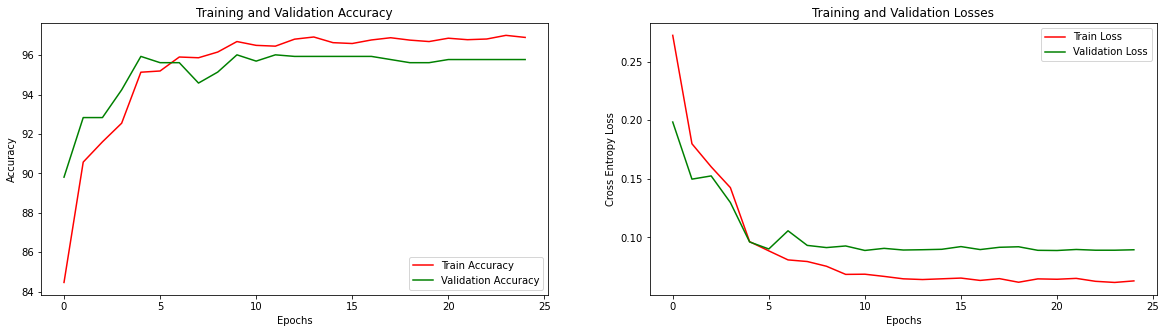

In [26]:
exp_model = load_pretrained_model('vgg16')
exp_criterion = nn.BCEWithLogitsLoss()
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000001)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=5, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'vgg16_ce_exp_1.pth',
                                       epochs=25,
                                       lr_scheduler=exp_scheduler)


In [27]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
y_pred, y_true, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}

exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

exp_logs['VGG16 - Exp1'] = {'desc': 'VGG16 - Exp1: SGD, LR=0.01', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_ce.pickle", "wb"))

Train Accuracy: 96.72 | F1 Score: 96.82
Validation Accuracy: 96.02 | F1 Score: 96.10


## Exp 2: SGD, LR=0.001
Divide LR by 10 after every 10 epochs

Loading Model...
Model Loaded


Train Epoch: 1 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:57<00:00, 52.75it/s]
LR: [0.001] | Train Loss: 0.254612 | Val Loss: 0.176178 | Train Acc: 83.95 | Val Acc: 91.16 | Val F1: 91.91
Train Epoch: 2 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.23it/s]
LR: [0.001] | Train Loss: 0.157396 | Val Loss: 0.180926 | Train Acc: 91.40 | Val Acc: 90.45 | Val F1: 91.08
Train Epoch: 3 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.26it/s]
LR: [0.001] | Train Loss: 0.140034 | Val Loss: 0.133798 | Train Acc: 92.24 | Val Acc: 92.36 | Val F1: 92.99
Train Epoch: 4 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.14it/s]
LR: [0.001] | Train Loss: 0.128145 | Val Loss: 0.119941 | Train Acc: 93.21 | Val Acc: 93.39 | Val F1: 93.67
Train Epoch: 5 / 25: 100%|█████████████████████████████████████████████████████████| 620

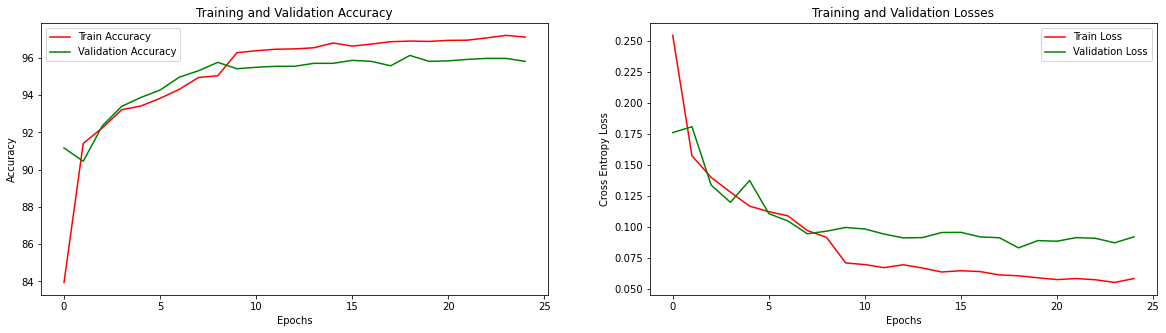

In [28]:
exp_model = load_pretrained_model('vgg16')
exp_criterion = nn.BCEWithLogitsLoss()
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.001, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=10, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'vgg16_ce_exp_2.pth',
                                       epochs=25,
                                       lr_scheduler=exp_scheduler)

In [29]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}


exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

exp_logs['VGG16 - Exp2'] = {'desc': 'VGG16 - Exp2: SGD, LR=0.001', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_ce.pickle", "wb"))

Train Accuracy: 96.80 | F1 Score: 96.94
Validation Accuracy: 96.13 | F1 Score: 96.34


<br><br><br><br>
# ResNet18
<br>

## Experiments

## Exp 1: SGD, LR=0.01
Divide LR by 10 after every 5 epochs

Loading Model...
Model Loaded


Train Epoch: 1 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:30<00:00, 201.87it/s]
LR: [0.01] | Train Loss: 0.223087 | Val Loss: 0.171979 | Train Acc: 87.17 | Val Acc: 89.62 | Val F1: 90.17
Train Epoch: 2 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:31<00:00, 197.65it/s]
LR: [0.01] | Train Loss: 0.152504 | Val Loss: 0.147997 | Train Acc: 91.32 | Val Acc: 93.52 | Val F1: 93.79
Train Epoch: 3 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:34<00:00, 180.10it/s]
LR: [0.01] | Train Loss: 0.141206 | Val Loss: 0.215541 | Train Acc: 92.35 | Val Acc: 88.88 | Val F1: 89.05
Train Epoch: 4 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:31<00:00, 195.40it/s]
LR: [0.01] | Train Loss: 0.121347 | Val Loss: 0.106704 | Train Acc: 93.46 | Val Acc: 94.35 | Val F1: 94.70
Train Epoch: 5 / 30: 100%|████████████████████████████████████████████████████████| 6200/620

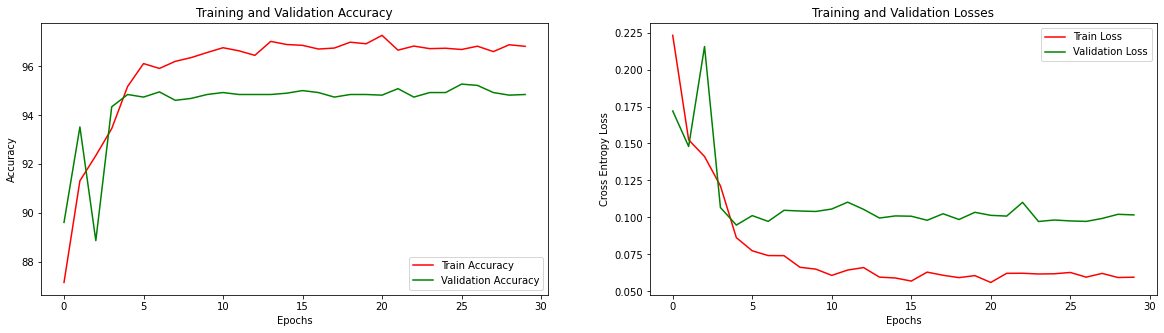

In [30]:
exp_model = load_pretrained_model('resnet18')
exp_criterion = nn.BCEWithLogitsLoss()
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.01, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=5, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'resnet18_ce_exp_1.pth',
                                       epochs=30,
                                       lr_scheduler=exp_scheduler)


In [31]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}


exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

exp_logs['ResNet18 - Exp1'] = {'desc': 'ResNet18 - Exp1: SGD, LR=0.01', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_ce.pickle", "wb"))

Train Accuracy: 97.48 | F1 Score: 97.53
Validation Accuracy: 95.28 | F1 Score: 95.46


## Exp 2: SGD, LR=0.001
Divide LR by 10 after every 10 epochs

Loading Model...
Model Loaded


Train Epoch: 1 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:30<00:00, 203.22it/s]
LR: [0.001] | Train Loss: 0.266566 | Val Loss: 0.197958 | Train Acc: 83.64 | Val Acc: 88.61 | Val F1: 89.77
Train Epoch: 2 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:31<00:00, 199.67it/s]
LR: [0.001] | Train Loss: 0.173748 | Val Loss: 0.166614 | Train Acc: 89.60 | Val Acc: 91.08 | Val F1: 91.88
Train Epoch: 3 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:33<00:00, 187.12it/s]
LR: [0.001] | Train Loss: 0.146480 | Val Loss: 0.146747 | Train Acc: 91.77 | Val Acc: 92.44 | Val F1: 92.95
Train Epoch: 4 / 30: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:31<00:00, 196.83it/s]
LR: [0.001] | Train Loss: 0.133664 | Val Loss: 0.133059 | Train Acc: 92.53 | Val Acc: 92.68 | Val F1: 93.07
Train Epoch: 5 / 30: 100%|████████████████████████████████████████████████████████| 6200

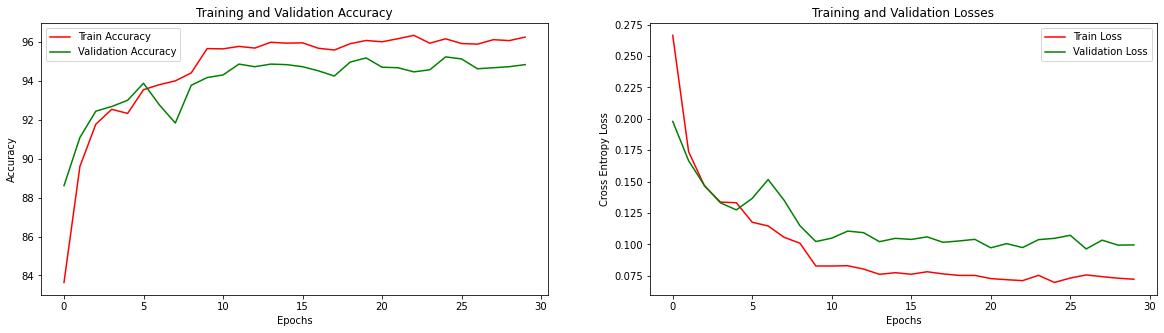

In [32]:
exp_model = load_pretrained_model('resnet18')
exp_criterion = nn.BCEWithLogitsLoss()
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.001, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=10, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'resnet18_ce_exp_2.pth',
                                       epochs=30,
                                       lr_scheduler=exp_scheduler)


In [33]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}


exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

exp_logs['ResNet18 - Exp2'] = {'desc': 'ResNet18 - Exp2: SGD, LR=0.001', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_ce.pickle", "wb"))

Train Accuracy: 96.99 | F1 Score: 97.10
Validation Accuracy: 95.22 | F1 Score: 95.38


<br><br><br>
## Comparing Results for Task1 (Cross Entropy)

### Combine Accuracy curves for all Fine Tuned Model Experiments

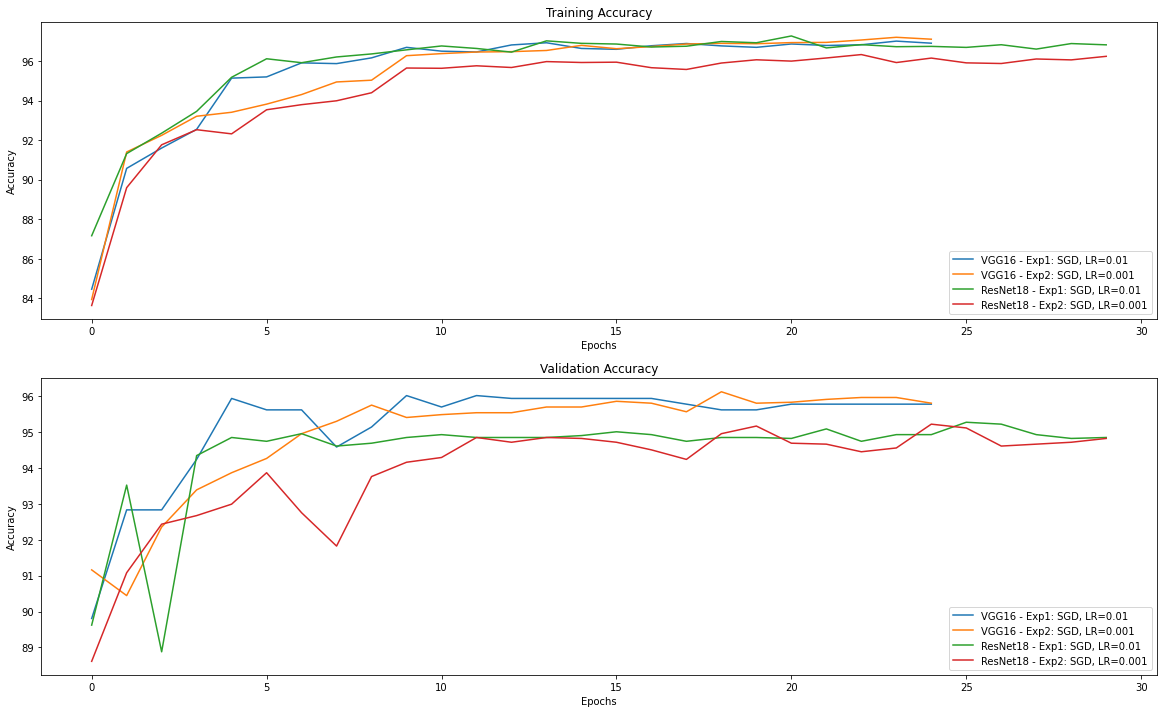

In [34]:
exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in exp_logs.values():
    ax[0].plot(log['history']['train_accuracy'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()

for log in exp_logs.values():
    ax[1].plot(log['history']['validation_accuracy'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
ax[1].legend()

plt.show()

### Combine Loss curves for Fine Tuned Model Experiments

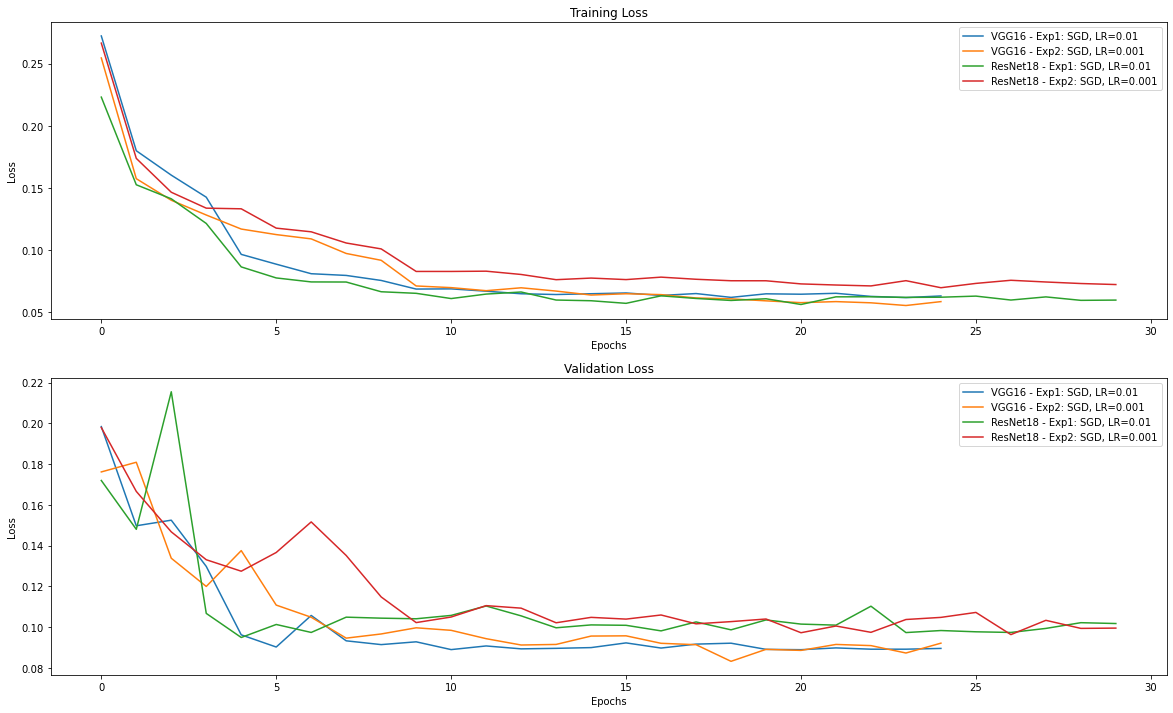

In [35]:
exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in exp_logs.values():
    ax[0].plot(log['history']['train_loss'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

for log in exp_logs.values():
    ax[1].plot(log['history']['validation_loss'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
ax[1].legend()

plt.show()

### Comparing Best Trained Model during each Experiment

In [40]:
exp_logs = pickle.load(open("exp_logs_ce.pickle", "rb"))

exp_results_df = pd.DataFrame([log['results'] for log in exp_logs.values()])
exp_results_df.insert(loc=0, column='Experiment', value=[i+1 for i in range(len(exp_logs.values()))])
exp_results_df.insert(loc=1, column='Desc', value=[log['desc'] for log in exp_logs.values()]) 
exp_results_df = exp_results_df.round({"acc_train":3, "acc_val":3, "f1_score_train":3, "f1_score_val":3}) 
exp_results_df.sort_values(['f1_score_val', 'acc_val'], ascending=[False, False])


,Experiment,Desc,acc_train,acc_val,f1_score_train,f1_score_val
1,2,"VGG16 - Exp2: SGD, LR=0.001",0.968,0.961,0.969,0.963
0,1,"VGG16 - Exp1: SGD, LR=0.01",0.967,0.960,0.968,0.961
2,3,"ResNet18 - Exp1: SGD, LR=0.01",0.975,0.953,0.975,0.955
3,4,"ResNet18 - Exp2: SGD, LR=0.001",0.970,0.952,0.971,0.954


### Saving best model

In [64]:
# model trained in experiment 3 is best one and already saved on disk, so just making copy of it with new name

# VGG16 Best Model
shutil.copy2('best models/vgg16_ce_exp_2.pth', 'vgg16_CE.pth')


# Resnet18 Best Model
shutil.copy2('best models/resnet18_ce_exp_1.pth', 'res18_CE.pth')

'res18_CE.pth'

# <br><br><br><center>Focal Loss</center><br><br><br>

In [24]:
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True, num_workers=NUM_WORKERS)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)

In [25]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        bce_loss = - nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(bce_loss)
        F_loss = - self.alpha * ((1-pt)**self.gamma) * bce_loss
        return torch.mean(torch.sum(F_loss, dim=1))

In [26]:
# exp_logs = {}
# pickle.dump(exp_logs, file = open("exp_logs_fl.pickle", "wb"))

## VGG16

## Experiments

### EXP 1: alpha=1, gamma=2

Loading Model...
Model Loaded


Train Epoch: 1 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:57<00:00, 52.77it/s]
LR: [0.01] | Train Loss: 0.242044 | Val Loss: 0.187506 | Train Acc: 80.97 | Val Acc: 88.77 | Val F1: 89.53
Train Epoch: 2 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:57<00:00, 52.64it/s]
LR: [0.01] | Train Loss: 0.160663 | Val Loss: 0.157260 | Train Acc: 89.10 | Val Acc: 91.53 | Val F1: 92.31
Train Epoch: 3 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.46it/s]
LR: [0.01] | Train Loss: 0.143155 | Val Loss: 0.124251 | Train Acc: 90.09 | Val Acc: 93.47 | Val F1: 93.79
Train Epoch: 4 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:57<00:00, 52.57it/s]
LR: [0.01] | Train Loss: 0.128165 | Val Loss: 0.162876 | Train Acc: 91.90 | Val Acc: 89.33 | Val F1: 89.89
Train Epoch: 5 / 25: 100%|█████████████████████████████████████████████████████████| 6200/62

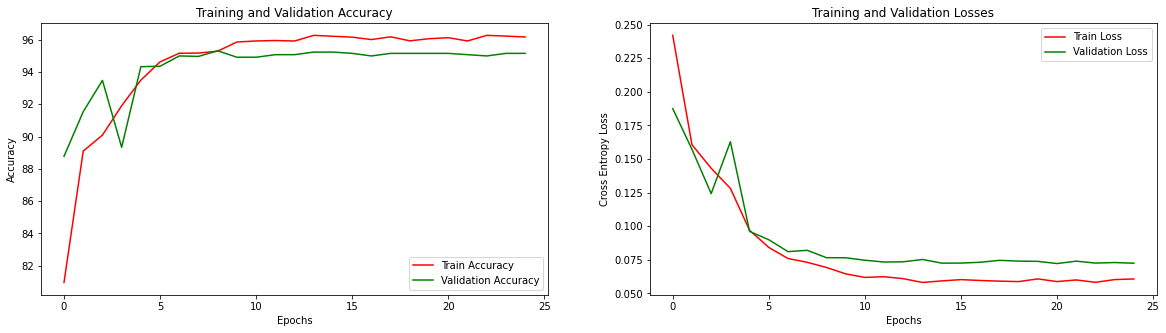

In [27]:
exp_model = load_pretrained_model('vgg16')
exp_criterion = FocalLoss(alpha=1, gamma=2)
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.01, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=5, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'vgg16_fl_exp_1.pth',
                                       epochs=25,
                                       lr_scheduler=exp_scheduler)


In [28]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}

exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

exp_logs['VGG16 - Exp1'] = {'desc': 'VGG16 - Exp1: alpha=1, gamma=2', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_fl.pickle", "wb"))

Train Accuracy: 95.48 | F1 Score: 95.65
Validation Accuracy: 95.30 | F1 Score: 95.58


### EXP 2: alpha=0.25, gamma = 2

Loading Model...


Train Epoch: 1 / 25:   0%|                                                                    | 0/6200 [00:00<?, ?it/s]

Model Loaded


Train Epoch: 1 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.26it/s]
LR: [0.01] | Train Loss: 0.049099 | Val Loss: 0.036310 | Train Acc: 84.69 | Val Acc: 91.32 | Val F1: 91.76
Train Epoch: 2 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.16it/s]
LR: [0.01] | Train Loss: 0.033644 | Val Loss: 0.030966 | Train Acc: 90.71 | Val Acc: 92.75 | Val F1: 93.03
Train Epoch: 3 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.18it/s]
LR: [0.01] | Train Loss: 0.029171 | Val Loss: 0.045391 | Train Acc: 92.24 | Val Acc: 88.77 | Val F1: 89.29
Train Epoch: 4 / 25: 100%|█████████████████████████████████████████████████████████| 6200/6200 [01:58<00:00, 52.14it/s]
LR: [0.01] | Train Loss: 0.026486 | Val Loss: 0.021815 | Train Acc: 92.85 | Val Acc: 94.56 | Val F1: 94.71
Train Epoch: 5 / 25: 100%|█████████████████████████████████████████████████████████| 6200/62

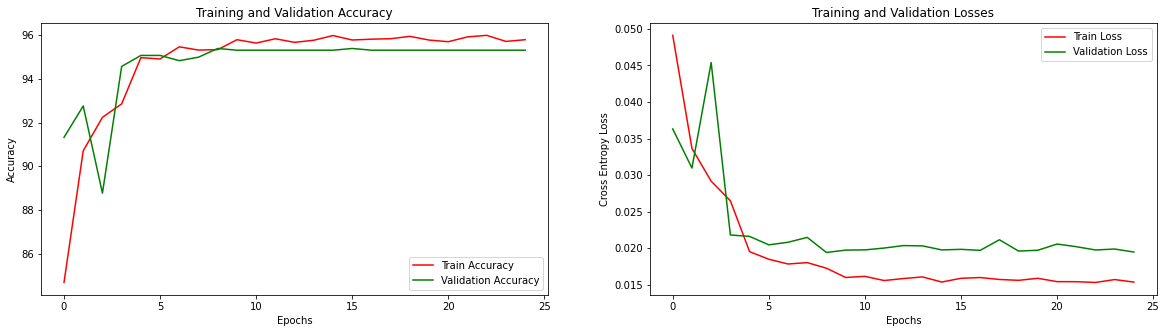

In [29]:
exp_model = load_pretrained_model('vgg16')
exp_criterion = FocalLoss(alpha=0.25, gamma=2)
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.01, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=5, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'vgg16_fl_exp_2.pth',
                                       epochs=25,
                                       lr_scheduler=exp_scheduler)


In [30]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}

exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

exp_logs['VGG16 - Exp2'] = {'desc': 'VGG16 - Exp2: alpha=0.25, gamma=2', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_fl.pickle", "wb"))

Train Accuracy: 96.15 | F1 Score: 96.27
Validation Accuracy: 95.38 | F1 Score: 95.46


<br><br><br><br>
# ResNet18
<br>

## Experiments

### EXP 1: alpha=1, gamma=2

Train Epoch: 1 / 25:   0%|                                                                    | 0/6200 [00:00<?, ?it/s]

Loading Model...
Model Loaded


Train Epoch: 1 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 193.07it/s]
LR: [0.01] | Train Loss: 0.274784 | Val Loss: 0.274972 | Train Acc: 82.08 | Val Acc: 70.30 | Val F1: 71.77
Train Epoch: 2 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 188.18it/s]
LR: [0.01] | Train Loss: 0.172027 | Val Loss: 0.296525 | Train Acc: 88.53 | Val Acc: 87.50 | Val F1: 87.78
Train Epoch: 3 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 190.84it/s]
LR: [0.01] | Train Loss: 0.150130 | Val Loss: 0.555046 | Train Acc: 90.10 | Val Acc: 84.42 | Val F1: 84.73
Train Epoch: 4 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 192.86it/s]
LR: [0.01] | Train Loss: 0.133157 | Val Loss: 0.137462 | Train Acc: 91.24 | Val Acc: 93.44 | Val F1: 93.67
Train Epoch: 5 / 25: 100%|████████████████████████████████████████████████████████| 6200/620

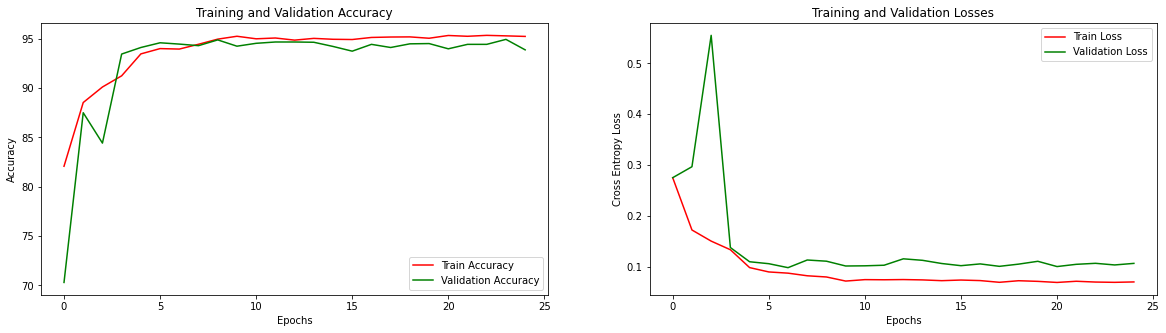

In [31]:
exp_model = load_pretrained_model('resnet18')
exp_criterion = FocalLoss(alpha=1, gamma=2)
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.01, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=5, gamma=0.1)
exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'resnet18_fl_exp_1.pth',
                                       epochs=25,
                                       lr_scheduler=exp_scheduler)


In [32]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
y_pred_val, y_true_val, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}

exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

exp_logs['ResNet18 - Exp1'] = {'desc': 'ResNet18 - Exp1: alpha=1, gamma=2', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_fl.pickle", "wb"))

Train Accuracy: 95.94 | F1 Score: 96.03
Validation Accuracy: 94.93 | F1 Score: 95.10


### EXP 2: alpha=0.25, gamma = 2

Train Epoch: 1 / 25:   0%|                                                                    | 0/6200 [00:00<?, ?it/s]

Loading Model...
Model Loaded


Train Epoch: 1 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:31<00:00, 195.91it/s]
LR: [0.01] | Train Loss: 0.050400 | Val Loss: 0.060776 | Train Acc: 85.02 | Val Acc: 86.44 | Val F1: 86.88
Train Epoch: 2 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 189.78it/s]
LR: [0.01] | Train Loss: 0.036041 | Val Loss: 0.032599 | Train Acc: 89.83 | Val Acc: 92.52 | Val F1: 92.99
Train Epoch: 3 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 189.61it/s]
LR: [0.01] | Train Loss: 0.029873 | Val Loss: 0.028360 | Train Acc: 91.54 | Val Acc: 93.34 | Val F1: 93.91
Train Epoch: 4 / 25: 100%|████████████████████████████████████████████████████████| 6200/6200 [00:32<00:00, 190.77it/s]
LR: [0.01] | Train Loss: 0.027127 | Val Loss: 0.027892 | Train Acc: 92.46 | Val Acc: 92.52 | Val F1: 92.89
Train Epoch: 5 / 25: 100%|████████████████████████████████████████████████████████| 6200/620

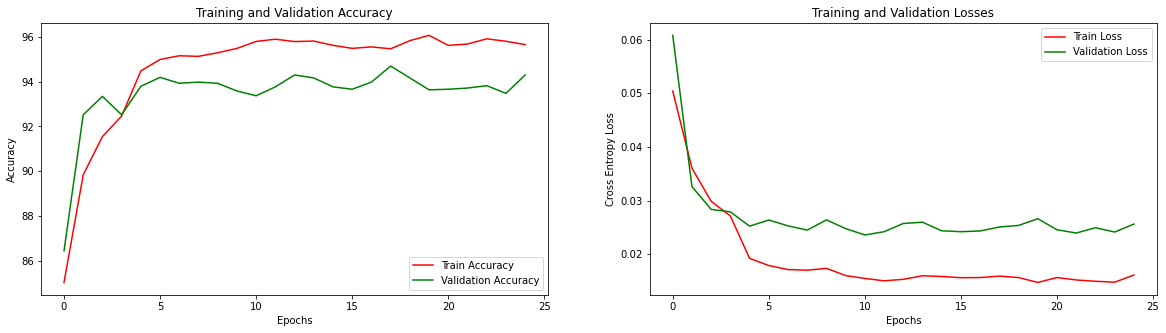

In [33]:
exp_model = load_pretrained_model('resnet18')
exp_criterion = FocalLoss(alpha=0.25, gamma=2)
exp_optimizer = optim.SGD(exp_model.parameters(), lr=0.01, momentum=0.9)
exp_scheduler = optim.lr_scheduler.StepLR(exp_optimizer, step_size=5, gamma=0.1)

exp_history, exp_best_model = train(model = exp_model,
                                       criterion = exp_criterion,
                                       optimizer = exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_name = 'resnet18_fl_exp_2.pth',
                                       epochs=25,
                                       lr_scheduler=exp_scheduler)


In [34]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(exp_best_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val}

exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

exp_logs['ResNet18 - Exp2'] = {'desc': 'ResNet18 - Exp2: alpha=0.25, gamma=2', 'results': results, 'history': exp_history}

pickle.dump(exp_logs, file = open("exp_logs_fl.pickle", "wb"))

Train Accuracy: 96.65 | F1 Score: 96.78
Validation Accuracy: 94.69 | F1 Score: 94.98


<br><br><br>
## Comparing Results for Focal Loss

### Combine Accuracy curves for all Fine Tuned Model Experiments

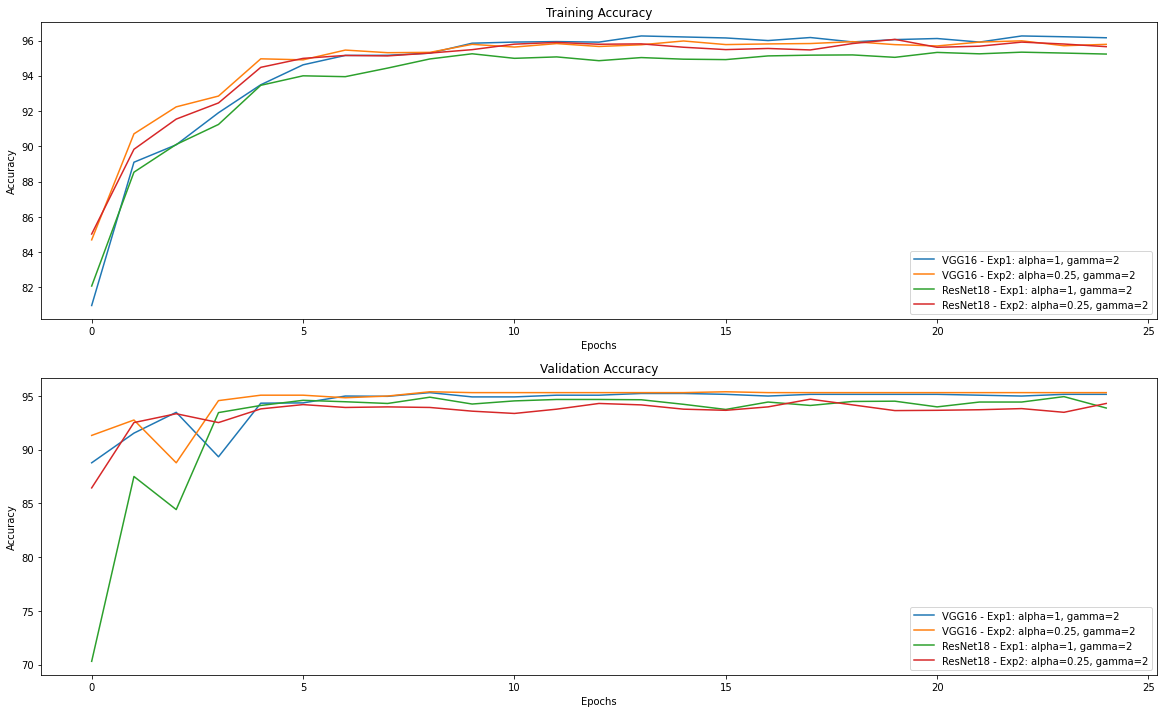

In [35]:
exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in exp_logs.values():
    ax[0].plot(log['history']['train_accuracy'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()

for log in exp_logs.values():
    ax[1].plot(log['history']['validation_accuracy'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
ax[1].legend()

plt.show()

### Combine Loss curves for Fine Tuned Model Experiments

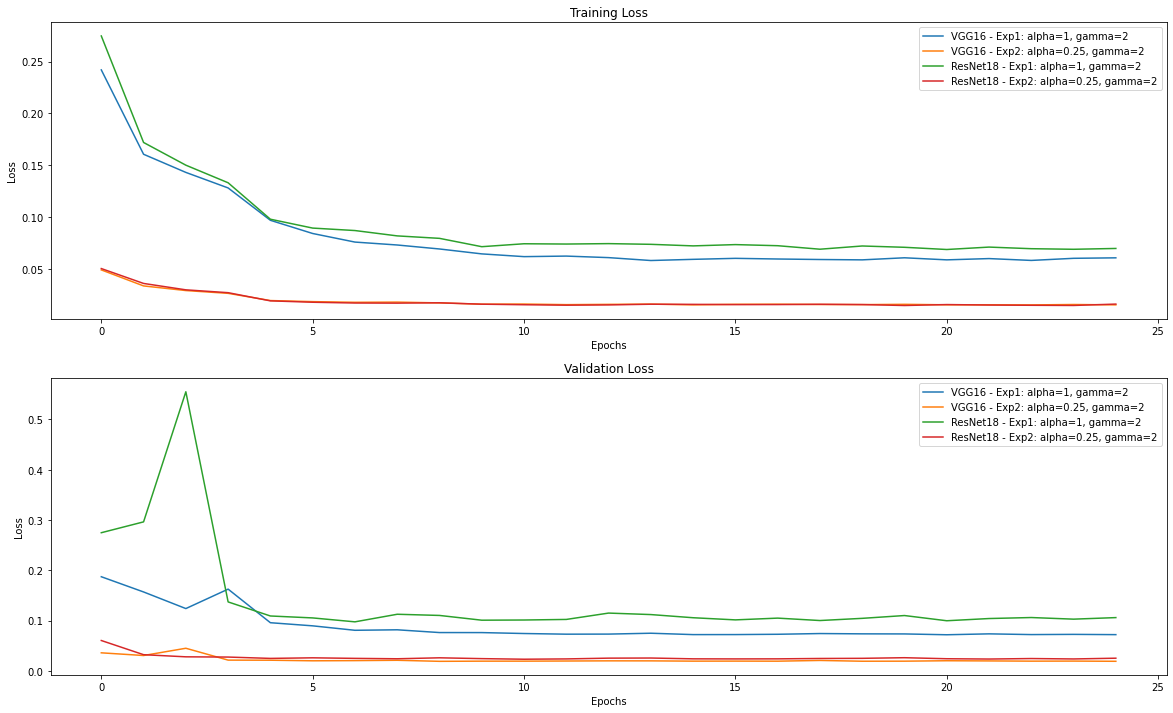

In [36]:
exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in exp_logs.values():
    ax[0].plot(log['history']['train_loss'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

for log in exp_logs.values():
    ax[1].plot(log['history']['validation_loss'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
ax[1].legend()

plt.show()

### Comparing Best Trained Model during each Experiment

In [37]:
exp_logs = pickle.load(open("exp_logs_fl.pickle", "rb"))

exp_results_df = pd.DataFrame([log['results'] for log in exp_logs.values()])
exp_results_df.insert(loc=0, column='Experiment', value=[i+1 for i in range(len(exp_logs.values()))])
exp_results_df.insert(loc=1, column='Desc', value=[log['desc'] for log in exp_logs.values()]) 
exp_results_df = exp_results_df.round({"acc_train":3, "acc_val":3, "f1_score_train":3, "f1_score_val":3}) 
exp_results_df.sort_values(['f1_score_val', 'acc_val'], ascending=[False, False])


,Experiment,Desc,acc_train,acc_val,f1_score_train,f1_score_val
0,1,"VGG16 - Exp1: alpha=1, gamma=2",0.955,0.953,0.957,0.956
1,2,"VGG16 - Exp2: alpha=0.25, gamma=2",0.961,0.954,0.963,0.955
2,3,"ResNet18 - Exp1: alpha=1, gamma=2",0.959,0.949,0.960,0.951
3,4,"ResNet18 - Exp2: alpha=0.25, gamma=2",0.967,0.947,0.968,0.950


### Saving best model

In [38]:
# model trained in experiment 3 is best one and already saved on disk, so just making copy of it with new name

# VGG16 Best Model
shutil.copy2('best models/vgg16_fl_exp_1.pth', 'vgg16_focal_loss.pth')


# Resnet18 Best Model
shutil.copy2('best models/resnet18_fl_exp_1.pth', 'res18_focal_loss.pth')

'res18_focal_loss.pth'

# <br><br><br><center>RESULTS</center><br><br><br>

In [39]:
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)

## VGG16 Cross Entropy

In [68]:
test_model = load_pretrained_model('vgg16')
test_model.load_state_dict(torch.load('vgg16_CE.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 97.03 | F1 Score: 97.17
Validation Accuracy: 96.13 | F1 Score: 96.34


Training Confusion Matrix


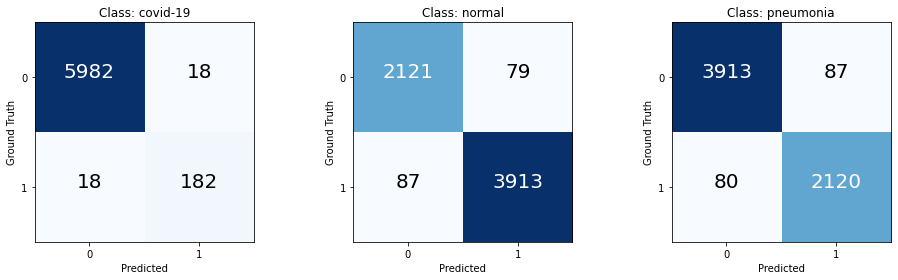




Validation Confusion Matrix


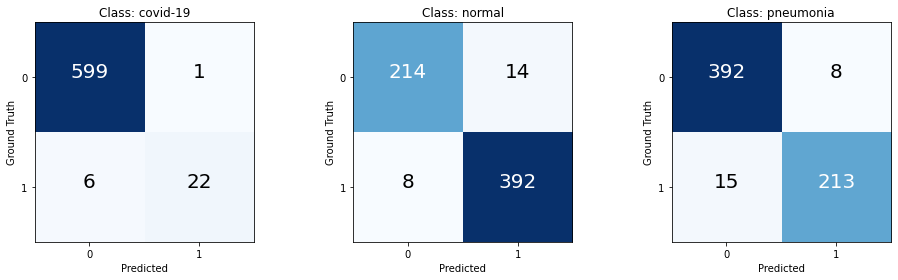

In [74]:
y_pred_train, y_true_train, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
y_pred_val, y_true_val, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

print('\n\nTraining Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_train, y_pred_train, np.array(classes))
print('\n\n\nValidation Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_val, y_pred_val, np.array(classes))

# ResNet18 Cross Entropy

In [77]:
test_model = load_pretrained_model('resnet18')
test_model.load_state_dict(torch.load('res18_CE.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 97.48 | F1 Score: 97.53
Validation Accuracy: 95.28 | F1 Score: 95.46


Training Confusion Matrix


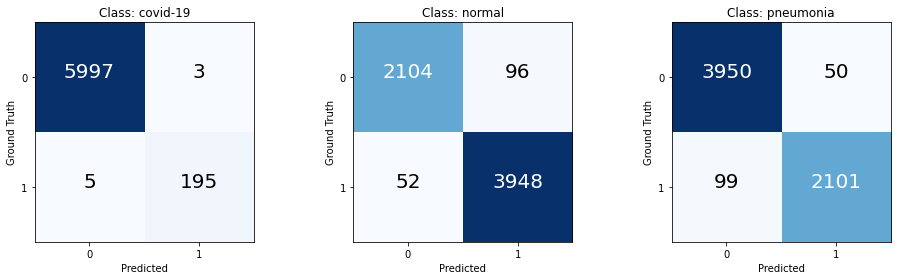




Validation Confusion Matrix


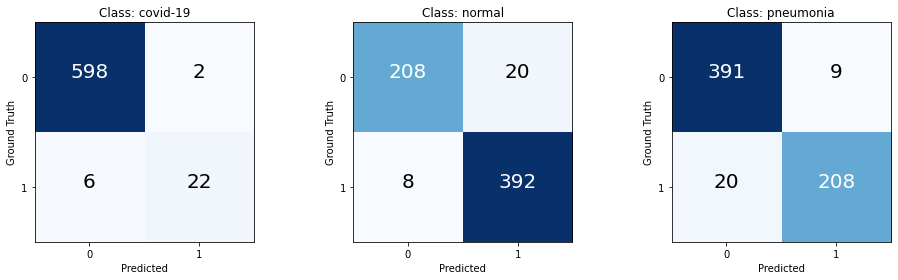

In [78]:
y_pred_train, y_true_train, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
y_pred_val, y_true_val, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

print('\n\nTraining Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_train, y_pred_train, np.array(classes))
print('\n\n\nValidation Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_val, y_pred_val, np.array(classes))

# VGG16 Focal Loss

In [40]:
test_model = load_pretrained_model('vgg16')
test_model.load_state_dict(torch.load('vgg16_focal_loss.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 95.83 | F1 Score: 95.96
Validation Accuracy: 95.30 | F1 Score: 95.58


Training Confusion Matrix


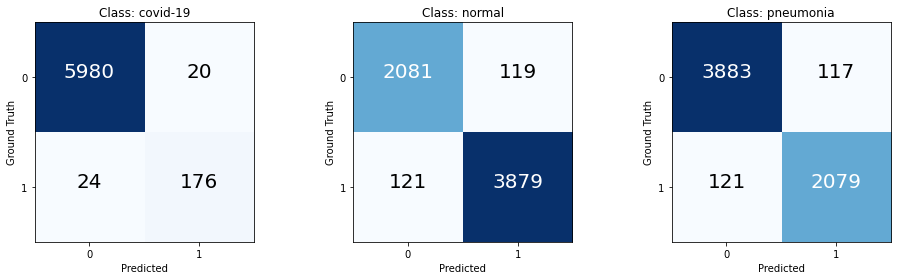




Validation Confusion Matrix


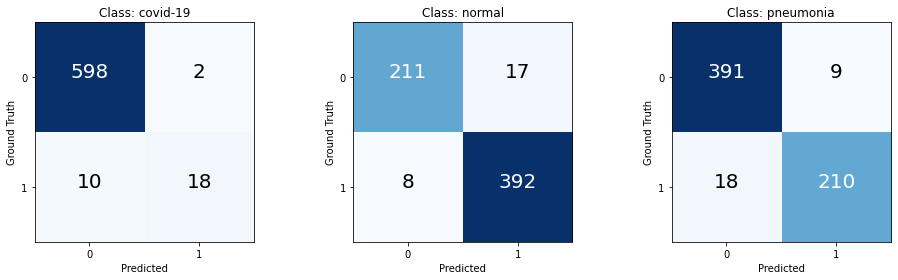

In [41]:
y_pred_train, y_true_train, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
y_pred_val, y_true_val, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

print('\n\nTraining Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_train, y_pred_train, np.array(classes))
print('\n\n\nValidation Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_val, y_pred_val, np.array(classes))

# ResNet18 Focal Loss

In [42]:
test_model = load_pretrained_model('resnet18')
test_model.load_state_dict(torch.load('res18_focal_loss.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 96.11 | F1 Score: 96.23
Validation Accuracy: 94.93 | F1 Score: 95.10


Training Confusion Matrix


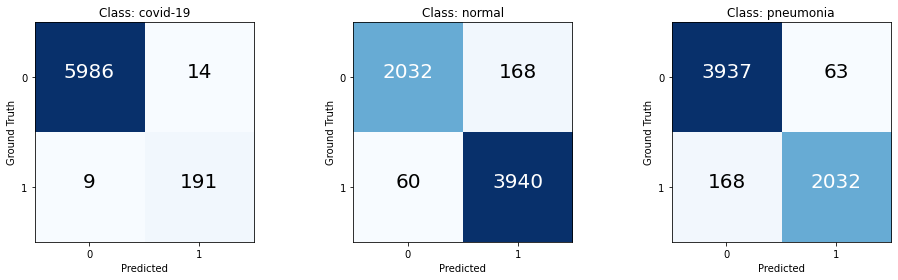




Validation Confusion Matrix


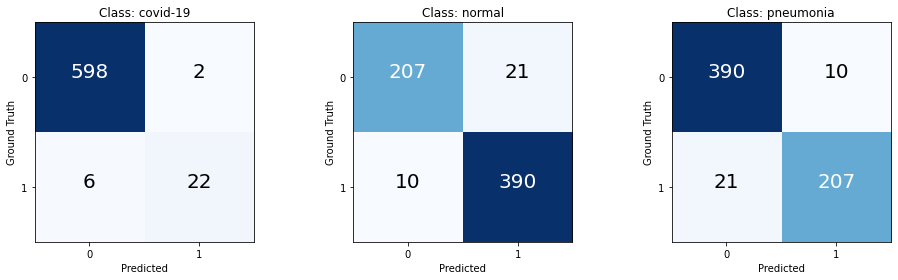

In [43]:
y_pred_train, y_true_train, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
y_pred_val, y_true_val, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)

print('Train Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_train * 100, f1_score_train * 100))
print('Validation Accuracy: {:.2f} | F1 Score: {:.2f}'.format(acc_val * 100, f1_score_val * 100))

print('\n\nTraining Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_train, y_pred_train, np.array(classes))
print('\n\n\nValidation Confusion Matrix')
plot_multilabel_confusion_matrix(y_true_val, y_pred_val, np.array(classes))

<br><br><br>
# Create Test Results File
<br><br>

In [84]:
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        data = super(CustomImageFolder, self).__getitem__(index)
        path = self.imgs[index][0]
        return (data + (path,))

In [85]:
## VGG16 performs best with Cross entropy, so creating test results with it
test_model = load_pretrained_model('vgg16')
test_model.load_state_dict(torch.load('vgg16_CE.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



In [101]:
test_data = CustomImageFolder(data_dir + '/Test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

test_submission = []

test_model.eval()
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = test_model(images)
        predicted = predict_labels(outputs.data).to(device)
        head, tail = os.path.split(paths[0])
        test_submission.append([tail, int(predicted[0][0].item()), int(predicted[0][2].item()), int(predicted[0][1].item())])

100%|████████████████████████████████████████████████████████████████████████████████| 629/629 [00:17<00:00, 35.40it/s]


In [102]:
results = pd.DataFrame(test_submission)
results.head()

,0,1,2,3
0,0.png,0,0,1
1,1.png,0,0,1
2,10.png,0,0,1
3,100.png,0,1,0
4,101.png,0,0,1


In [106]:
results.to_csv('msds19078_results.csv', encoding='utf-8', index=False, header=False)